In [55]:
# download temp mean data for Global 2m temps (GFS Ensemble 0.5 Degree Bias-Corrected)
# doc: at https://nomads.ncep.noaa.gov/
# this will take multiple minutes
import os
import requests
import time
from bs4 import BeautifulSoup
ts = ['00', '06', '12', '18']
basedate = '20231001'
# select from above times and modify date 
t_multi = ts[3]

# CONFIGURATION FOR FORECASTS TO DOWNLOAD (only last two days are available)
# MAKE SURE THERE IS NO TRAILING SLASH
base_urls = []
if type(t_multi) is list:
    for t in t_multi:
        base_urls.append(
            f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/gefs.{basedate}/" + t + "/pgrb2ap5_bc"
        )
else:
    t = t_multi
    base_urls.append(
            f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/gefs.{basedate}/" + t + "/pgrb2ap5_bc"
    )

# for comparison
cfsr_extrapolate_year = 2023
cfsr_filepath = '../cfsr_world_t2_day.json'

In [56]:
def download_file(url, folder_path):
    response = requests.get(url)
    file_name = os.path.basename(url)
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'wb') as f:
        f.write(response.content)

def get_file_urls(base_url, t):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    urls = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if href and not href.startswith('../') and href.startswith('geavg.t' + t + 'z.pgrb2a.0p50_bcf') and 'idx' not in href:
            urls.append(href)
    return urls

num_urls = len(base_urls)
cur_url_count = 0
for base_url in base_urls:
    folder_path = os.path.basename(os.path.normpath(
        base_url.split('/')[-3]
    ))
    t = base_url.split('/')[-2]
    folder_path += '_' + t
    print(folder_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    cur_url_count += 1
    print(f"Processing {cur_url_count} / {num_urls} folders to download GEFS, bias corrected, 2m ensemble mean temperatures")

    file_urls = get_file_urls(base_url, t)
    time.sleep(2)
    i = 0
    numfiles = len(file_urls)
    for file_url in file_urls:
        download_url = f"https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/{base_url.split('https://nomads.ncep.noaa.gov/pub/data/nccf/com/naefs/prod/')[-1]}&file={file_url}&var_TMP=on&lev_2_m_above_ground=on"
        i += 1
        print(f" - Downloading {i} / {numfiles} : {download_url}")
        download_file(download_url, folder_path)
        time.sleep(2)  # Pause for 2 seconds between downloads

gefs.20231001_18
Processing 1 / 1 folders to download GEFS, bias corrected, 2m ensemble mean temperatures
 - Downloading 1 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf003&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 2 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf006&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 3 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf009&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 4 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf012&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 5 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf015&var_TMP=on&lev_2_m_

 - Downloading 46 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf138&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 47 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf141&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 48 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf144&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 49 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf147&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 50 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf150&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 51 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

 - Downloading 91 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf354&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 92 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf360&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 93 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf366&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 94 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf372&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 95 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/gefs.20231001/18/pgrb2ap5_bc&file=geavg.t18z.pgrb2a.0p50_bcf378&var_TMP=on&lev_2_m_above_ground=on
 - Downloading 96 / 96 : https://nomads.ncep.noaa.gov/cgi-bin/filter_gensbc.pl?dir=/g

In [57]:
# calculate averages for downloaded forecast data

import pygrib
import numpy as np
from datetime import datetime, timedelta
import os
import glob

def get_date_from_offset(date_string, offset_hours):
    date_format = "%Y%m%d"
    date = datetime.strptime(date_string, date_format)
    result_date = date + timedelta(hours=offset_hours)
    return result_date

def date_to_time_str(date_time):
    date_format = "%Y-%m-%d %H:%M:%S"
    time_str = date_time.strftime(date_format)
    return time_str

def date_to_day_str(date_time):
    date_format = "%m-%d-%Y"
    month_day_year = date_time.strftime(date_format)
    return month_day_year

def day_str_to_date(date_string):
    date_format = "%m-%d-%Y"
    date = datetime.strptime(date_string, date_format)
    return date

def kelvin_to_celsius(kelvin_temperature):
    celsius_temperature = kelvin_temperature - 273.15
    return celsius_temperature

def get_average_temperature(file_path):
    grbs = pygrib.open(file_path)
    # first get the forecast avg temp for that time step
    forecast_temperatures = {}
    for grb in grbs:
        # there should only be one entry even this is a for loop
        date = grb.dataDate
        # hours offset from forecast
        forecastTime = grb.forecastTime
        # calculate the valid time for this data
        valid_time = get_date_from_offset(str(date), forecastTime)
        time_str = date_to_time_str(valid_time)
            
        # each step is in units of hours, with intervals of every 3 hours
        # this is a forecast so the first hour is missing (only in analysis data)
        # there should only be one value
        if '2 metre temperature' in grb.name:
            avg = kelvin_to_celsius(grb.average)
            forecast_temperatures[valid_time] = avg
    grbs.close()
    return forecast_temperatures

def process_files_in_folder(folder_path):
    file_list = sorted(glob.glob(os.path.join(folder_path, "*")))
    num_files = len(file_list)
    print(f"--   Processing {num_files} files...")
    last_date = None
    max_temp = None
    averages_for_folder = []
    forecast_temperatures = {}
    complete_averages = {}
    # keep track of first day to skip adding it to complete_averages
    first_day = True
    for file_path in file_list:
        # get average temperature for step (should only be one time step)
        forecast_temperatures.update(get_average_temperature(file_path))
    
    # calculate the average for each day
    last_day_str = None
    day_averages = []
    last_avg = None
    for valid_time, avg in forecast_temperatures.items():
        # handle case for first observation
        if last_day_str is None:
            last_day_str = date_to_day_str(valid_time)

        day_str = date_to_day_str(valid_time)
        if day_str == last_day_str:
            # time step in same day
            day_averages.append(avg)
        else:
            # time step goes to next day
            # print out the previous day's average first
            
            day_average = np.average(day_averages)
            if last_avg == None:
                last_avg = day_average
            day_over_day_delta = day_average - last_avg
            if not first_day or len(day_averages) != 7:
                print(f"Global 2m temp average (C) for {last_day_str}: {day_average:6.3f} (day over day delta: {day_over_day_delta:6.3f})")
                yesterday_time = day_str_to_date(last_day_str)
                complete_averages[yesterday_time] = day_average
            # clear the list for the new day
            day_averages = []
            # change the last_day
            last_day_str = day_str
            # add the current day's average to the list
            day_averages.append(avg)
            last_avg = day_average

            # set first day done
            first_day = False
    return complete_averages

In [79]:
import json
from datetime import datetime, timedelta
def get_date(day_of_year, year):
    # Create a datetime object for January 1st of the given year
    base_date = datetime(year, 1, 1)
    
    # Add the number of days to the base date to get the target date
    target_date = base_date + timedelta(days=day_of_year - 1)
    
    # Format the date as "{Month} {Day}, {Year}"
    formatted_date = target_date.strftime("%Y-%m-%d")
    
    return formatted_date
   
def get_days_in_year(year):
    if year % 4 == 0:
        if year % 100 == 0:
            if year % 400 == 0:
                return 366  # Leap year (divisible by 400)
            else:
                return 365  # Not a leap year (divisible by 100 but not by 400)
        else:
            return 366  # Leap year (divisible by 4 but not by 100)
    else:
        return 365  # Not a leap year

def get_cfsr_temps(cfsr_filepath, cfsr_extrapolate_year):
    # Step 1: Load and parse the JSON file
    with open(cfsr_filepath) as file:
        data = json.load(file)

    # Step 2: Filter the data to include only four-digit years
    # Include only extrapolate year
    filtered_data = [entry['data'] for entry in data if entry['name'] == str(cfsr_extrapolate_year)]

    # Step 3: Extract temperature series data (ignore null values) and use date as key
    temp_series = {}
    for i, temp in enumerate(filtered_data[0]):
        # ignore null values (null place holders at the end of the data for non-leap years)
        if temp:
            temp_date = get_date(i+1, cfsr_extrapolate_year)
            temp_series[temp_date] = temp
    return temp_series

def get_today_date():
    date_now = datetime.now()
    return datetime(date_now.year, date_now.month, date_now.day)

In [59]:
## CONFIGURE TO FOLDER NAMES
#folders = ["gefs.20230726", "gefs.20230727", "gefs.20230728", "gefs.20230729", "gefs.20230730", "gefs.20230731", "gefs.20230801", "gefs.20230802", "gefs.20230803", "gefs.20230804", "gefs.20230805", "gefs.20230805_12", "gefs.20230805_18", "gefs.20230806"]  # Add more folders if needed
# Get a list of all items in the current directory
items = os.listdir()
# Filter out only the folder names
unsorted_folders = [item for item in items if os.path.isdir(item)]
# Sort the folder names in alphabetical order
folders = sorted(unsorted_folders)
complete_averages = {}

for folder in folders:
    if 'gefs' in folder:
        folder_path = os.path.join(".", folder)  # Adjust the path if 
        print(f"-- Processing {folder_path}")
        complete_averages[folder] = process_files_in_folder(folder_path)

-- Processing ./gefs.20230920_00
--   Processing 96 files...
Global 2m temp average (C) for 09-21-2023:  8.140 (day over day delta: -0.006)
Global 2m temp average (C) for 09-22-2023:  8.067 (day over day delta: -0.073)
Global 2m temp average (C) for 09-23-2023:  7.903 (day over day delta: -0.164)
Global 2m temp average (C) for 09-24-2023:  7.727 (day over day delta: -0.175)
Global 2m temp average (C) for 09-25-2023:  7.529 (day over day delta: -0.199)
Global 2m temp average (C) for 09-26-2023:  7.389 (day over day delta: -0.140)
Global 2m temp average (C) for 09-27-2023:  7.191 (day over day delta: -0.198)
Global 2m temp average (C) for 09-28-2023:  7.004 (day over day delta: -0.187)
Global 2m temp average (C) for 09-29-2023:  6.902 (day over day delta: -0.102)
Global 2m temp average (C) for 09-30-2023:  6.794 (day over day delta: -0.108)
Global 2m temp average (C) for 10-01-2023:  6.654 (day over day delta: -0.140)
Global 2m temp average (C) for 10-02-2023:  6.570 (day over day delta:

Global 2m temp average (C) for 09-23-2023:  8.047 (day over day delta: -0.238)
Global 2m temp average (C) for 09-24-2023:  7.893 (day over day delta: -0.154)
Global 2m temp average (C) for 09-25-2023:  7.744 (day over day delta: -0.149)
Global 2m temp average (C) for 09-26-2023:  7.482 (day over day delta: -0.262)
Global 2m temp average (C) for 09-27-2023:  7.279 (day over day delta: -0.203)
Global 2m temp average (C) for 09-28-2023:  7.220 (day over day delta: -0.060)
Global 2m temp average (C) for 09-29-2023:  7.209 (day over day delta: -0.011)
Global 2m temp average (C) for 09-30-2023:  7.141 (day over day delta: -0.067)
Global 2m temp average (C) for 10-01-2023:  7.090 (day over day delta: -0.051)
Global 2m temp average (C) for 10-02-2023:  7.046 (day over day delta: -0.044)
Global 2m temp average (C) for 10-03-2023:  6.910 (day over day delta: -0.136)
Global 2m temp average (C) for 10-04-2023:  6.855 (day over day delta: -0.055)
Global 2m temp average (C) for 10-05-2023:  6.839 (d

Global 2m temp average (C) for 09-24-2023:  7.867 (day over day delta: -0.077)
Global 2m temp average (C) for 09-25-2023:  7.571 (day over day delta: -0.297)
Global 2m temp average (C) for 09-26-2023:  7.313 (day over day delta: -0.258)
Global 2m temp average (C) for 09-27-2023:  7.134 (day over day delta: -0.179)
Global 2m temp average (C) for 09-28-2023:  7.013 (day over day delta: -0.121)
Global 2m temp average (C) for 09-29-2023:  6.826 (day over day delta: -0.187)
Global 2m temp average (C) for 09-30-2023:  6.710 (day over day delta: -0.116)
Global 2m temp average (C) for 10-01-2023:  6.654 (day over day delta: -0.056)
Global 2m temp average (C) for 10-02-2023:  6.660 (day over day delta:  0.006)
Global 2m temp average (C) for 10-03-2023:  6.693 (day over day delta:  0.033)
Global 2m temp average (C) for 10-04-2023:  6.633 (day over day delta: -0.060)
Global 2m temp average (C) for 10-05-2023:  6.575 (day over day delta: -0.058)
Global 2m temp average (C) for 10-06-2023:  6.610 (d

Global 2m temp average (C) for 09-26-2023:  7.366 (day over day delta: -0.149)
Global 2m temp average (C) for 09-27-2023:  7.197 (day over day delta: -0.170)
Global 2m temp average (C) for 09-28-2023:  7.051 (day over day delta: -0.146)
Global 2m temp average (C) for 09-29-2023:  6.901 (day over day delta: -0.150)
Global 2m temp average (C) for 09-30-2023:  6.837 (day over day delta: -0.064)
Global 2m temp average (C) for 10-01-2023:  6.829 (day over day delta: -0.008)
Global 2m temp average (C) for 10-02-2023:  6.805 (day over day delta: -0.024)
Global 2m temp average (C) for 10-03-2023:  6.747 (day over day delta: -0.058)
Global 2m temp average (C) for 10-04-2023:  6.683 (day over day delta: -0.064)
Global 2m temp average (C) for 10-05-2023:  6.672 (day over day delta: -0.010)
Global 2m temp average (C) for 10-06-2023:  6.647 (day over day delta: -0.025)
Global 2m temp average (C) for 10-07-2023:  6.612 (day over day delta: -0.035)
Global 2m temp average (C) for 10-08-2023:  6.569 (d

Global 2m temp average (C) for 09-28-2023:  7.032 (day over day delta: -0.188)
Global 2m temp average (C) for 09-29-2023:  6.956 (day over day delta: -0.076)
Global 2m temp average (C) for 09-30-2023:  6.850 (day over day delta: -0.106)
Global 2m temp average (C) for 10-01-2023:  6.814 (day over day delta: -0.036)
Global 2m temp average (C) for 10-02-2023:  6.762 (day over day delta: -0.051)
Global 2m temp average (C) for 10-03-2023:  6.633 (day over day delta: -0.129)
Global 2m temp average (C) for 10-04-2023:  6.490 (day over day delta: -0.144)
Global 2m temp average (C) for 10-05-2023:  6.444 (day over day delta: -0.045)
Global 2m temp average (C) for 10-06-2023:  6.455 (day over day delta:  0.011)
Global 2m temp average (C) for 10-07-2023:  6.479 (day over day delta:  0.024)
Global 2m temp average (C) for 10-08-2023:  6.477 (day over day delta: -0.002)
Global 2m temp average (C) for 10-09-2023:  6.503 (day over day delta:  0.026)
Global 2m temp average (C) for 10-10-2023:  6.540 (d

Global 2m temp average (C) for 09-30-2023:  6.898 (day over day delta: -0.101)
Global 2m temp average (C) for 10-01-2023:  6.915 (day over day delta:  0.017)
Global 2m temp average (C) for 10-02-2023:  6.777 (day over day delta: -0.138)
Global 2m temp average (C) for 10-03-2023:  6.579 (day over day delta: -0.198)
Global 2m temp average (C) for 10-04-2023:  6.444 (day over day delta: -0.135)
Global 2m temp average (C) for 10-05-2023:  6.502 (day over day delta:  0.058)
Global 2m temp average (C) for 10-06-2023:  6.648 (day over day delta:  0.146)
Global 2m temp average (C) for 10-07-2023:  6.654 (day over day delta:  0.006)
Global 2m temp average (C) for 10-08-2023:  6.665 (day over day delta:  0.011)
Global 2m temp average (C) for 10-09-2023:  6.748 (day over day delta:  0.082)
Global 2m temp average (C) for 10-10-2023:  6.733 (day over day delta: -0.014)
Global 2m temp average (C) for 10-11-2023:  6.713 (day over day delta: -0.021)
Global 2m temp average (C) for 10-12-2023:  6.743 (d

Global 2m temp average (C) for 10-01-2023:  6.888 (day over day delta: -0.042)
Global 2m temp average (C) for 10-02-2023:  6.725 (day over day delta: -0.163)
Global 2m temp average (C) for 10-03-2023:  6.449 (day over day delta: -0.276)
Global 2m temp average (C) for 10-04-2023:  6.280 (day over day delta: -0.169)
Global 2m temp average (C) for 10-05-2023:  6.253 (day over day delta: -0.027)
Global 2m temp average (C) for 10-06-2023:  6.389 (day over day delta:  0.136)
Global 2m temp average (C) for 10-07-2023:  6.633 (day over day delta:  0.244)
Global 2m temp average (C) for 10-08-2023:  6.784 (day over day delta:  0.151)
Global 2m temp average (C) for 10-09-2023:  6.788 (day over day delta:  0.004)
Global 2m temp average (C) for 10-10-2023:  6.763 (day over day delta: -0.025)
Global 2m temp average (C) for 10-11-2023:  6.766 (day over day delta:  0.004)
Global 2m temp average (C) for 10-12-2023:  6.745 (day over day delta: -0.021)
Global 2m temp average (C) for 10-13-2023:  6.716 (d

In [60]:
# strip plot for each day

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# linear bias correction to see if there is a correlation (matching trends)
def bias_correct_gefs(temps, gefs_avg, cfsr_avg, v):
    bc_temps = []
    c0 = -gefs_avg
    #v = 0.25
    c1 = cfsr_avg
    for temp in temps:
        # zero out the gefs temp
        # reduce the range
        # bias back to the average cfsr for that period
        bc_temp = (v * (temp + c0)) + c1
        bc_temps.append(bc_temp)
    return bc_temps

In [93]:
import numpy as np
import json

def mse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean() 

def graph_strip_plot(forecast, record, cfsr = None, biasFactor = None):
    fig, ax = plt.subplots(figsize=(12, 12))
    # Create a list of all data points and their corresponding labels
    data = []
    labels = []
    hue = []
    if cfsr is not None:
        cfsr_temps = []
        cfsr_num_days = 0
        for date, temp in cfsr.items():
            cfsr_temps.append(temp)
            cfsr_num_days += 1
        cfsr_avg = np.average(cfsr_temps)
    gefs_temps = []
    gefs_day_temp_avgs = []
    gefs_num_days = 0
    for date, temps in forecast.items():
        gefs_num_days += 1
        if cfsr is None or gefs_num_days <= cfsr_num_days:
            gefs_temps.extend(temps)
    gefs_avg = np.average(gefs_temps)
    
    # find bias factor to minimize MSE
    min_v = None
    min_mse = None
    if cfsr is not None:
        for v in np.arange(0, 1, 0.0001):
            # do it again for bc temps averaged for each day ( necessary to calculate mse )
            gefs_num_days = 0
            gefs_bc_temps_day_avg = []
            for date, temps in forecast.items():
                gefs_num_days += 1
                if gefs_num_days <= cfsr_num_days:
                    bc_temps = bias_correct_gefs(temps, gefs_avg, cfsr_avg, v)
                    bc_temps_day_avg = np.average(bc_temps)
                    gefs_bc_temps_day_avg.append(bc_temps_day_avg)
            #print(cfsr_temps)
            #print(gefs_bc_temps_day_avg)
            gefs_bc_mse = mse(cfsr_temps, gefs_bc_temps_day_avg)
            if min_mse is None:
                min_mse = gefs_bc_mse
                min_v = v
            if gefs_bc_mse < min_mse:
                min_mse = gefs_bc_mse
                min_v = v
        print(f"Bias factor (discovered) v: {min_v:1.5f}, MSE: {gefs_bc_mse:1.5f}")
        v = min_v

    if biasFactor is not None:
        print(f"Using bias factor passed: {biasFactor}")
        v = biasFactor
        
    predTemps = []
    for date, temps in forecast.items():
        if cfsr is None:
            gefs_temps = temps
        else:
            gefs_temps = bias_correct_gefs(temps, gefs_avg, cfsr_avg, v)
        data.extend(gefs_temps)
        # treat the date as a whole string
        labels.extend([date] * len(gefs_temps))
        hue.extend(['Forecasts'] * len(gefs_temps))
    
        day_avg_temp = np.average(gefs_temps)
        # append the day average also
        data.append(day_avg_temp)
        print(day_avg_temp)
        predTemps.append(day_avg_temp)
        labels.append(date)
        hue.append('GEFS Day Avg.')
        
    try:
        with open('pred_temps.json') as file:
            predData = json.load(file)
    except:
        predData = {}
    predData[date_to_day_str(get_today_date())] = predTemps
    with open('pred_temps.json', 'w') as file:
        json.dump(predData, file)

    if cfsr is not None:
        for date, temp in cfsr.items():
            data.append(temp)
            # treat the date as a whole string
            labels.append(date)
            hue.append('CFSR')
        # Set the style of the strip plot
        sns.stripplot(x=labels, y=data, hue=hue, dodge=True, jitter=0.1, alpha=0.9, palette=['#1f77b4', '#ff7f0e', '#ffdf00'], linewidth=0)
    else:
        #print(labels)
        #print(data)
        # Set the style of the strip plot
        sns.stripplot(x=labels, y=data, hue=hue, dodge=True, jitter=0.1, alpha=0.9, palette=['#1f77b4', '#ff7f0e'], linewidth=0)

    #plt.subplots_adjust(wspace=-1)

    # Add a horizontal line at the rise threshold
    ax.axhline(y=record, color='g', linestyle='--')

    # Set the y-axis label
    ax.set_ylabel('Forecast Global Avg. Temperature (C)')

    # Set the x-axis to be at the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=85)
    
    # Set more subticks on the y-axis
    #plt.yticks(np.arange(-1.0, 1.6, 0.1))

    # Increase spacing between each day
    #plt.subplots_adjust(wspace=0.6)
    
    # add cfsr to title
    if cfsr is not None:
        title_cfsr = '\n' + '(linear bias correction on GEFS-BC forecasts to match CFSR)'
    else:
        title_cfsr = ''
    # Add a title to the chart
    plt.title('Forecasted Global Daily Temperature Averages' + '\n' + 
              'Derived from GEFS (Bias-Corrected, Mean) 2m Temperature Forecasts' +
              title_cfsr
    )

    # Show the plot
    plt.show()

Bias factor (discovered) v: 0.23060, MSE: 0.14740
Using bias factor passed: 0.4677
16.663149722459032
16.6229108824284
16.54872623412535
16.49879245029603
16.42062530593545
16.30609884978698
16.226643799324535
16.171763838410794
16.119711678941393
16.079316023334002
16.051639666016474
16.014014484559294
15.950654691080375
15.90956262070228
15.898299247276897
15.91154194771198
15.937669286158098
15.962207125780099
15.974810547305676
15.96823996525738
15.964916363857434
15.956491300944446
15.964129651607625
15.940495100156674
15.903607133470373
15.87949361327907


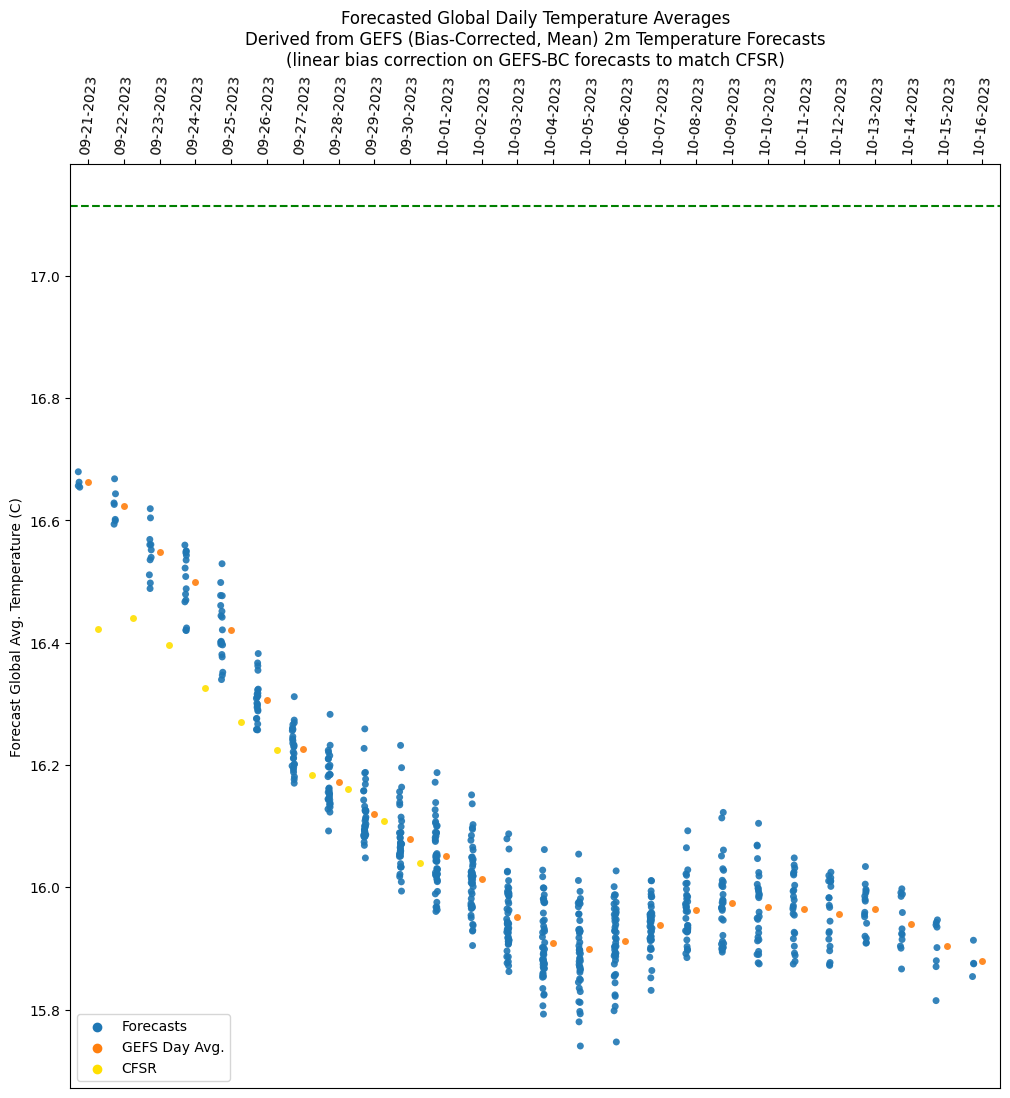

In [94]:
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 500em; }</style>"))

forecast = {}

# exclude forecasts older than this date, or set to None for ALL
#min_forecast_date = "2023-08-19"
min_forecast_date = "2023-09-20"

# overlay cfsr data in observations?
overlay_cfsr = True

# get cfsr data for extrapolate year
cfsr_temps_extrapolate_year = get_cfsr_temps(cfsr_filepath, cfsr_extrapolate_year)    
cfsr_temps_in_forecast_period = {}

for folder_name, complete_average in complete_averages.items():
    # each forecast has a set of forecast dates
    # use if want to prune old forecasts
    short_date = folder_name.split('.')[1].split('_')[0]
    

    # Date to compare in the format YYYY-MM-DD
    if min_forecast_date:
        compare_date = datetime.strptime(min_forecast_date, "%Y-%m-%d")
    else:
        compare_date = None
        
    # Convert the short date to a comparable format
    short_date_dt = datetime.strptime(short_date, "%Y%m%d")
    # Compare the dates
    if not compare_date or compare_date <= short_date_dt:
        for valid_time, forecast_average in complete_average.items():
            day_str = date_to_day_str(valid_time)
            if day_str not in forecast:
                forecast[day_str] = []
            temps = forecast[day_str]
            temps.append(forecast_average)
            forecast[day_str] = temps
            #print(f"{day_str} : {forecast_average}")
            
            # add the cfsr temps for that date if available
            cfsr_date_str = valid_time.strftime("%Y-%m-%d")
            if cfsr_date_str in cfsr_temps_extrapolate_year:
                cfsr_temps_in_forecast_period[day_str] = cfsr_temps_extrapolate_year[cfsr_date_str]
            
if overlay_cfsr:
    # bias corrected gefs, overlay cfsr (use cfsr record)
    record = 17.114
    #graph_strip_plot(forecast, record, cfsr_temps_in_forecast_period, 0.21680)
    # use 0.46770 (best fit for August)
    graph_strip_plot(forecast, record, cfsr_temps_in_forecast_period, 0.46770)
    #graph_strip_plot(forecast, record, cfsr_temps_in_forecast_period)
else:    
    # CFSR record was on August 2. GEFS forecast for August 2 on previous day (t=00) was 8.592
    record = 8.592
    graph_strip_plot(forecast, record)

In [201]:
monthly_cfsr_file_path = '/home/db/Documents/JRPdata/monthly-mean-land-ocean-temp/cfsr_world_t2_day.json'
data = {}
with open(monthly_cfsr_file_path) as file:
    data = json.load(file)

In [202]:
from datetime import datetime, date, timedelta
temp_pred_start_date_str = '09-21-2023'
temp_pred_start_day_num = int(day_str_to_date(temp_pred_start_date_str).strftime('%j'))

yesterday_date = get_today_date() - timedelta(days=1)
yesterday_day_num = int(yesterday_date.strftime('%j'))

temp_pred_index_start_from_today = yesterday_day_num - temp_pred_start_day_num + 1
temp_pred_from_today = []
with open('pred_temps.json') as file:
    predData = json.load(file)
    temp_pred_from_today = predData[date_to_day_str(get_today_date())][temp_pred_index_start_from_today:]

In [203]:
# how much to increase 2016 temps by for remainder of forecast
offset_2016_temps = 0.0

add_to_end_2016_temps = []
for i in range(len(data)):
    y = data[i]['name']
    if y == '2016':
        e = data[i]
        temps = e['data']
        after_forecast_index = yesterday_day_num + len(temp_pred_from_today) + 1
        temps_2016_after_forecast = temps[after_forecast_index:]
        adj_temps_for_2016 = np.add(temps_2016_after_forecast, offset_2016_temps).tolist()
        add_to_end_2016_temps = adj_temps_for_2016
    if y == '2023':
        e = data[i]
        temps = e['data']
        index_first_none = temps.index(None)
        temp_preds = temp_pred_from_today + add_to_end_2016_temps
        print(f"Diff from last forecast day to next using 2016 temps w/ offset: {temp_pred_from_today[-1] - add_to_end_2016_temps[0]:.4f}")
        # sanity check to make sure have updated CFSR file
        if (index_first_none - 1) == (yesterday_day_num - 1):
            for j in range(len(temp_preds)):
                temp_j = temp_preds[j]
                temps[index_first_none + j] = np.around(temp_j, 3)
            e['data'] = temps
            data[i] = e

monthly_cfsr_forecast_file_path = '/home/db/Documents/JRPdata/monthly-mean-land-ocean-temp/cfsr_world_t2_day_forecast.json'
# overwrite missing days with forecast avg.
with open(monthly_cfsr_forecast_file_path, 'w') as file:
    json.dump(data, file)

Diff from last forecast day to next using 2016 temps w/ offset: 0.9035
